In [7]:
from __future__ import print_function
import anndata as ad
import numpy as np
import pandas as pd
import logging
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import random

import anndata as ad
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

import plotly.io as plt_io
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
from sklearn.metrics import mean_squared_error
#import umap
from tensorflow import keras

from keras.models import Model
from keras.layers import Dense, Input
from keras.regularizers import l1
from tensorflow.keras.optimizers import Adam 
import tensorflow as tf
tf.config.run_functions_eagerly(True)

import torch
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
from sklearn.metrics.pairwise import euclidean_distances
from scipy import sparse
import math

# Read data

In [9]:
adata_gex = ad.read_h5ad("cite_gex_processed_training.h5ad")
adata_adt = ad.read_h5ad("cite_adt_processed_training.h5ad")
train_cells = adata_gex.obs_names[adata_gex.obs["batch"] != "s1d2"]
test_cells  = adata_gex.obs_names[adata_gex.obs["batch"] == "s1d2"]
input_train_mod1 = adata_gex[train_cells]
input_train_mod2 = adata_adt[train_cells]
input_test_mod1 =  adata_gex[test_cells]

true_test_mod2 =  adata_adt[test_cells]
number_of_rows = input_train_mod1.X.shape[0]
random_indices = np.random.choice(number_of_rows, size=3000, replace=False)
gex_subset = input_train_mod1.X[random_indices, :]
adt_subset = input_train_mod2.X[random_indices, :]
y = input_train_mod2.X[random_indices, :].toarray()
cell_types_gex = input_train_mod1.obs.iloc[random_indices, :]['cell_type'].values
cell_types_adt = input_train_mod2.obs.iloc[random_indices, :]['cell_type'].values

In [10]:
no_ret = (input_train_mod1.obs.iloc[random_indices, :]['cell_type']!='Reticulocyte').values

gex_subset_not_ret = gex_subset[no_ret]
gex_subset_not_ret

<2855x13953 sparse matrix of type '<class 'numpy.float64'>'
	with 4126715 stored elements in Compressed Sparse Column format>

In [11]:
exclude = ['Plasma cell IGKC+','Reticulocyte','Plasmablast IGKC-','Plasma cell IGKC-','Plasmablast IGKC+','Normoblast']
no_every = (~input_train_mod1.obs.iloc[random_indices, :]['cell_type'].isin(exclude)).values
gex_subset_ev = gex_subset[no_every]
gex_subset_ev

<2750x13953 sparse matrix of type '<class 'numpy.float64'>'
	with 4022768 stored elements in Compressed Sparse Column format>

In [12]:
cell_types_gex_not_ret= input_train_mod1.obs.iloc[random_indices, :][no_every]['cell_type'].values
len(cell_types_gex_not_ret)

2750

# Convert Data into tensor

In [13]:
all_data_gex = input_train_mod1.X
all_cell_types_gex = input_train_mod1.obs['cell_type'].values

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
coo = all_data_gex.tocoo()
values = coo.data
indices = np.vstack((coo.row, coo.col))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo.shape
all_gex_torch_data = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense().to(device)

all_data_adt = input_train_mod2.X
all_cell_types_adt = input_train_mod2.obs['cell_type'].values

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
coo = all_data_adt.tocoo()
values = coo.data
indices = np.vstack((coo.row, coo.col))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo.shape
all_adt_torch_data = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense().to(device)

# Define Loss Functions

In [14]:
#d_matrix_origin = euclidean_distances(gex_subset_not_ret, gex_subset_not_ret)
#t_distance_org = tf.convert_to_tensor(d_matrix_origin,dtype='float32')

def my_loss_test(code,curbatch):
    #gex_torch_dist_matrix = (torch.cdist(gex_torch_data[curindex:curindex+size],gex_torch_data[curindex:curindex+size]))
    torch_dist_matrix = torch.cdist(cur_batch,cur_batch)
    D = (torch.cdist(code,code))
    #denom = torch.add(torch_dist_matrix,D)
    #ratio = torch.divide((torch_dist_matrix-D),denom)
    return (1/code.shape[0])*torch.sum(torch.absolute(torch_dist_matrix-D))

def pairwise(code,curbatch):
    d_embedding = torch.pdist(code)
    d_org = torch.pdist(curbatch)
    los = nn.MSELoss()
    denom = torch.add(d_embedding,d_org)
    ratio = torch.divide((torch.absolute(d_embedding-d_org)),denom)
    #return los(d_embedding,d_org)
    return torch.sum(torch.absolute(ratio))#*(1/math.comb(d_embedding.shape[0],2))



In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
coo = gex_subset.tocoo()
values = coo.data
indices = np.vstack((coo.row, coo.col))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo.shape
gex_torch_data = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense().to(device)

coo = adt_subset.tocoo()
values = coo.data
indices = np.vstack((coo.row, coo.col))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo.shape
adt_torch_data = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense().to(device)

# Create Autoencoder for ADT (Protein)

In [16]:
class AE_adt(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # create layers
        self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=100)
        self.encoder_output_layer100 = nn.Linear(in_features=100, out_features=64)
        self.normalize = nn.LayerNorm(64)
        self.encoder_output_layer64 = nn.Linear(in_features=64, out_features=32)
        
        self.encoder_output_layer32 = nn.Linear(in_features=32, out_features=2)
        
        self.decoder_hidden_layer32d = nn.Linear(in_features=2, out_features=32)
        self.decoder_hidden_layer64d = nn.Linear(in_features=32, out_features=64)
        self.decoder_hidden_layer100d = nn.Linear(in_features=64, out_features=100)
        self.decoder_output_layer = nn.Linear(in_features=100, out_features=kwargs["input_shape"])

    def forward(self, features):
        # create network
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        activation = self.encoder_output_layer100(activation)
        activation = torch.relu(activation)
        
        activation = self.normalize (activation)
        
        activation = self.encoder_output_layer64(activation)
        activation = torch.relu(activation)
        code = self.encoder_output_layer32(activation)
        
        activation = self.decoder_hidden_layer32d(code)
        activation = torch.relu(activation)
        activation = self.decoder_hidden_layer64d(activation)
        activation = torch.relu(activation)
        activation = self.decoder_hidden_layer100d(activation)
        activation = torch.relu(activation)
        
        activation = self.decoder_output_layer(activation)
        return [code,activation]

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_adt = AE_adt(input_shape=134).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-4
optimizer_adt = optim.Adam(model_adt.parameters(), lr=1e-4)

criterion_mse = nn.MSELoss()
criterion_pairwise = pairwise

In [19]:
num_points_gex = gex_torch_data.shape[0]
num_points_adt = adt_torch_data.shape[0]
num_points_gex

3000

# Train ADT Autoencoder

In [21]:
x,y = [],[]
for epoch in range(1000):
    loss = 0
    num_points = adt_torch_data.shape[0]
    #permutation = torch.randperm(adt_torch_data.shape[0])
    permutation = torch.randperm(adt_torch_data.shape[0])
    for i in range(0,num_points,100):
        indices = permutation[i:i+100]
        #cur_batch = adt_torch_data[indices]
        cur_batch = adt_torch_data[indices]
        #cur_batch = adt_torch_data[i:i+100]
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer_adt.zero_grad()
        
        # compute reconstructions
        outputs = model_adt(cur_batch)[1]
        code_output = model_adt(cur_batch)[0]
        
        train_loss_mse = criterion_mse(outputs, cur_batch)
        train_loss = criterion_pairwise(code_output,cur_batch)+train_loss_mse
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer_adt.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / num_points
    
    # display the epoch training loss
    #print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, 5, loss))
    x.append(loss)
    y.append(epoch+1)

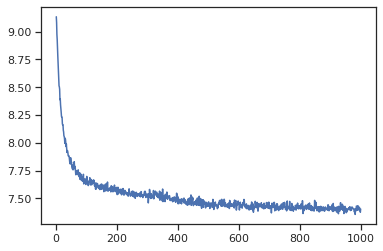

In [22]:
plt.plot(y, x)

# Visualize

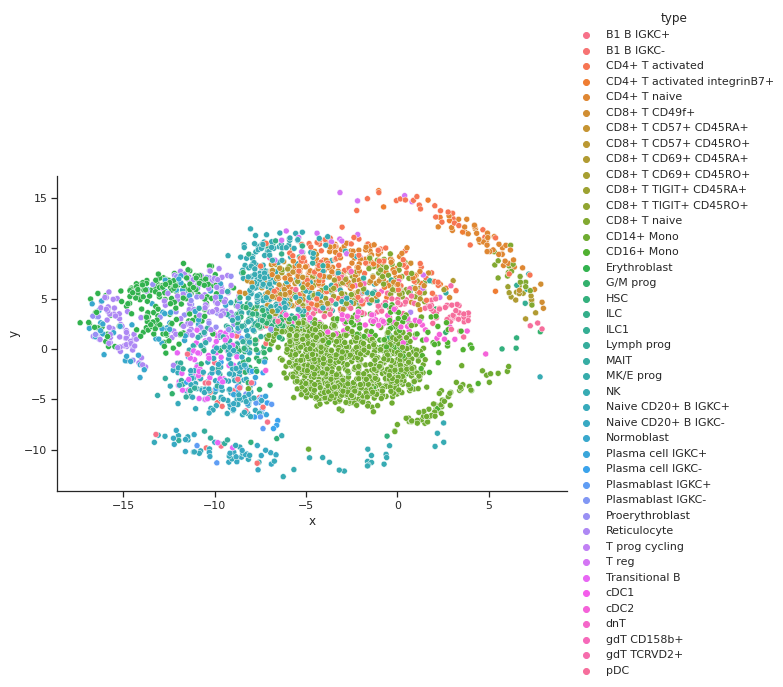

In [24]:
#auto_latent_gex = model_gex(gex_torch_data)[0]
#df_gex = pd.DataFrame({'x':auto_latent_gex[:,0].cpu().detach().numpy(),'y':auto_latent_gex[:,1].cpu().detach().numpy(),'type':cell_types_gex_not_ret})
auto_latent_adt = model_adt(adt_torch_data)[0]
df_adt = pd.DataFrame({'x':auto_latent_adt[:,0].cpu().detach().numpy(),'y':auto_latent_adt[:,1].cpu().detach().numpy(),'type':cell_types_adt})

#sns.relplot(data=df_gex, x='x', y='y', hue='type', aspect=1.61, )
sns.relplot(data=df_adt, x='x', y='y', hue='type', aspect=1.61, )

In [25]:
adt_og_d = euclidean_distances(adt_subset, adt_subset).ravel()
latent_d = euclidean_distances(auto_latent_adt.cpu().detach().numpy(),auto_latent_adt.cpu().detach().numpy()).ravel()
protein_df = pd.DataFrame(data={'original_adt': adt_og_d, 'code': latent_d})

latent_cap = protein_df.code.quantile(.75)

new_adt_df = protein_df[protein_df['original_adt'] < 10]
new_adt_df.loc[new_adt_df['code'] > latent_cap, 'code'] = latent_cap

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


<Figure size 432x288 with 0 Axes>

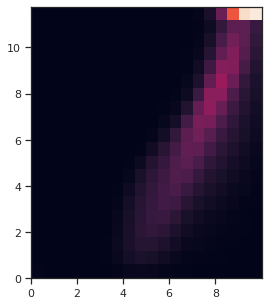

In [26]:
heatmap_adt, xedges_adt, yedges_adt = np.histogram2d(new_adt_df['original_adt'], new_adt_df['code'], bins=20)
extent_adt = [xedges_adt[0], xedges_adt[-1], yedges_adt[0], yedges_adt[-1]]

plt.clf()
plt.figure(figsize=(5, 5))
plt.imshow(heatmap_adt.T, extent=extent_adt, origin='lower')
plt.show()

# Create autoencoder for GEX (Gene Expression, MRNA)

In [27]:
class AE_gex(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer256 = nn.Linear(in_features=kwargs["input_shape"], out_features=1000)
        self.normalize = nn.LayerNorm(1000)
        self.encoder_hidden_layer128 = nn.Linear(in_features=1000, out_features=128)
        self.encoder_hidden_layer64 = nn.Linear(in_features=128, out_features=64)
        self.encoder_output_layer = nn.Linear(in_features=64, out_features=2)
        
        self.decoder_hidden_layer = nn.Linear(in_features=2, out_features=64)
        self.decoder_hidden_layer64d = nn.Linear(in_features=64, out_features=128)
        self.decoder_hidden_layer128d = nn.Linear(in_features=128, out_features=1000)
        self.decoder_output_layer = nn.Linear(in_features=1000, out_features=kwargs["input_shape"])

    def forward(self, features):
        activation = self.encoder_hidden_layer256(features)
        activation = torch.relu(activation)
        activation = self.normalize(activation)
        activation = self.encoder_hidden_layer128(activation)
        activation = torch.relu(activation)
        activation = self.encoder_hidden_layer64(activation)
        
        code = self.encoder_output_layer(activation)
        
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        
        activation = self.decoder_hidden_layer64d(activation)
        activation = torch.relu(activation)
        activation = self.decoder_hidden_layer128d(activation)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return [code,activation]

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gex = AE_gex(input_shape=13953).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer_gex = optim.Adam(model_gex.parameters(), lr=1e-4)
criterion_mse = nn.MSELoss()
criterion = my_loss_test
criterion_pairwise = pairwise

# Train

In [35]:
x,y = [],[]
num_points =gex_torch_data.shape[0]
for epoch in range(2000):
    loss = 0
    permutation = torch.randperm(gex_torch_data.shape[0])
    for i in range(0,num_points,100):
        indices = permutation[i:i+100]
        cur_batch = gex_torch_data[indices]
        optimizer_gex.zero_grad()
        
        # compute reconstructions
        outputs = model_gex(cur_batch)[1]
        code_output = model_gex(cur_batch)[0]
        
        train_loss = criterion_mse(outputs, cur_batch)

        train_loss.backward()
        
        optimizer_gex.step()
        loss += train_loss.item()
    
    loss = loss / num_points
    
    #print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, 5, loss))
    x.append(loss)
    y.append(epoch+1)

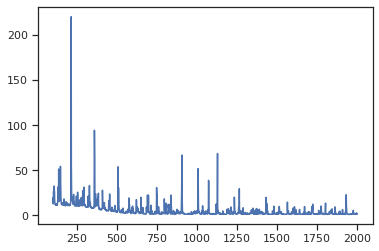

In [36]:
plt.plot(y[100:],x[100:])

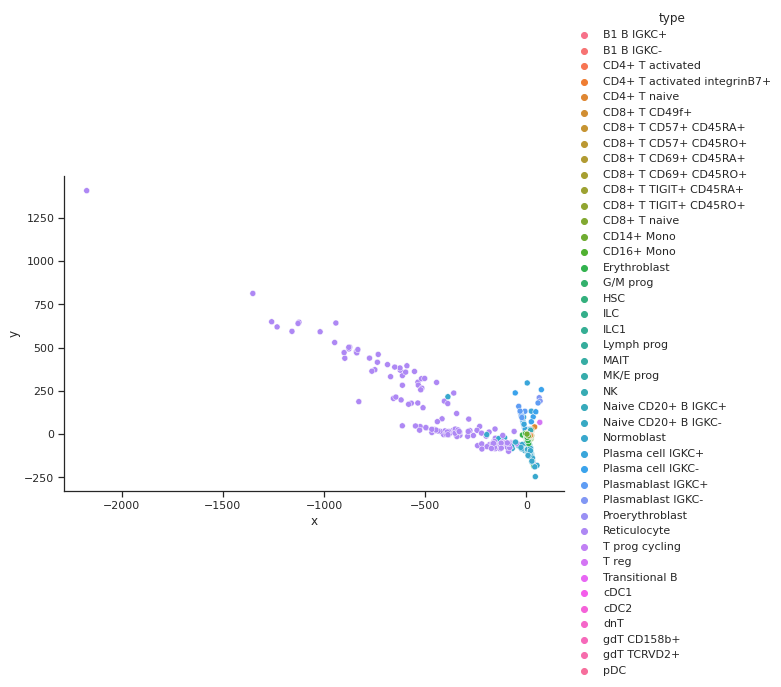

In [37]:
auto_latent_gex = (model_gex(gex_torch_data)[0])
df_gex = pd.DataFrame({'x':auto_latent_gex[:,0].cpu().detach().numpy(),'y':auto_latent_gex[:,1].cpu().detach().numpy(),'type':cell_types_gex})
sns.relplot(data=df_gex, x='x', y='y', hue='type', aspect=1.61, )

In [38]:
gex_og_d = euclidean_distances(gex_subset, gex_subset).ravel()
latent_d_gex = euclidean_distances(auto_latent_gex.cpu().detach().numpy(),auto_latent_gex.cpu().detach().numpy()).ravel()
protein_df_gex = pd.DataFrame(data={'original_gex': gex_og_d, 'code': latent_d_gex})

latent_cap_gex = protein_df_gex.code.quantile(.75)

new_gex_df = protein_df_gex[protein_df_gex['original_gex'] < 10]
new_gex_df.loc[new_gex_df['code'] > latent_cap_gex, 'code'] = latent_cap_gex

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<Figure size 432x288 with 0 Axes>

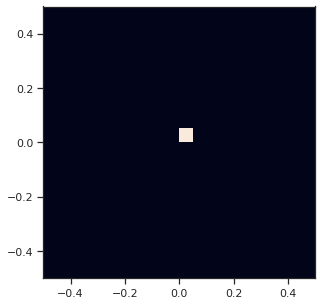

In [39]:
heatmap_gex, xedges_gex, yedges_gex = np.histogram2d(new_gex_df['original_gex'], new_gex_df['code'], bins=20)
extent_gex = [xedges_gex[0], xedges_gex[-1], yedges_gex[0], yedges_gex[-1]]

plt.clf()
plt.figure(figsize=(5, 5))
plt.imshow(heatmap_gex.T, extent=extent_gex, origin='lower')
plt.show()